# Experiments in Calibrating Zero-Shot Image Classifiers

This notebooks contains code for experimenting with different calibration methods for binary classifiers, applied to the use case of zero-shot image classification.

## Install Dependencies

In [1]:
! pip install open_clip_torch
! pip install --upgrade datasets
! pip install relplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Import Libraries

In [2]:
import pathlib

import datasets
import matplotlib.pyplot as plt
import numpy as np
import open_clip
import pandas as pd
import PIL.Image
import PIL.PngImagePlugin
import relplot
import scipy.special
import sklearn.calibration
import sklearn.isotonic
import sklearn.metrics
import sklearn.model_selection
import torch
import tqdm.auto as tqdm

# fix image loading errors for some large files
PIL.PngImagePlugin.MAX_TEXT_CHUNK = 100 * (1024**2)

## Fetch Datasets

In [3]:
DATASET_URLS = {
    # Aerial Image Dataset: https://captain-whu.github.io/AID/
    "aid": "https://drive.google.com/uc?id=1CTdCFoo88_ygMb2PNGnK3QTi8xk_naoA",
    # MIT Places 365: http://places2.csail.mit.edu/
    "places365": "https://drive.google.com/uc?id=1w-0LncVMfBsdtqX7jT-jCTdAnLBZuFtU",
}

In [4]:
for dataset_name, dataset_gdrive_url in DATASET_URLS.items():
    ! gdown {dataset_gdrive_url}
    ! mkdir {dataset_name}
    ! unzip /content/{dataset_name}.zip -d {dataset_name}
    ! rm /content/{dataset_name}.zip

Downloading...
From (original): https://drive.google.com/uc?id=1CTdCFoo88_ygMb2PNGnK3QTi8xk_naoA
From (redirected): https://drive.google.com/uc?id=1CTdCFoo88_ygMb2PNGnK3QTi8xk_naoA&confirm=t&uuid=0c2f68ab-735f-4c1d-91ee-3b4caaa42563
To: /content/aid.zip
100% 66.2M/66.2M [00:01<00:00, 33.3MB/s]
Archive:  /content/aid.zip
  inflating: aid/state.json          
  inflating: aid/dataset_info.json   
  inflating: aid/data-00000-of-00001.arrow  
Downloading...
From (original): https://drive.google.com/uc?id=1w-0LncVMfBsdtqX7jT-jCTdAnLBZuFtU
From (redirected): https://drive.google.com/uc?id=1w-0LncVMfBsdtqX7jT-jCTdAnLBZuFtU&confirm=t&uuid=7119a439-fab1-48c6-b550-ca8f6be0455f
To: /content/places365.zip
100% 960M/960M [00:18<00:00, 51.3MB/s]
Archive:  /content/places365.zip
  inflating: places365/state.json    
  inflating: places365/dataset_info.json  
  inflating: places365/data-00002-of-00003.arrow  
  inflating: places365/data-00000-of-00003.arrow  
  inflating: places365/data-00001-of-00003

## Implement Zero-Shot Classifier and Calibrators

In [5]:
class ZeroShotClassifier:
    """Wrapper for loading and running zero-shot image classifiers."""

    TEMPLATES = [
        "itap of a {}.",
        "a bad photo of the {}.",
        "a origami {}.",
        "a photo of the large {}.",
        "a {} in a video game.",
        "art of the {}.",
        "a photo of the small {}.",
    ]

    def __init__(self, model_name, pretrained_source, device):
        """Create a new instance of the zero-shot classifier."""
        self.model_name = model_name
        self.pretrained_source = pretrained_source
        self.device = device
        self.model, _, self.preprocess = open_clip.create_model_and_transforms(
            self.model_name,
            pretrained=self.pretrained_source,
        )
        self.model.eval().to(device)
        self.tokenizer = open_clip.get_tokenizer(self.model_name)
        self.text = None
        self.text_features = None

    def set_text(self, text):
        """Set the text prompt for the classifier."""
        self.text = text
        tokens = self.tokenizer(
            [t.format(self.text) for t in ZeroShotClassifier.TEMPLATES]
        )
        with torch.no_grad(), torch.amp.autocast("cuda"):
            text_features = self.model.encode_text(tokens.to(self.device))
            text_features /= text_features.norm(dim=-1, keepdim=True)
            text_features = text_features.mean(dim=0)
            text_features /= text_features.norm()
        self.text_features = text_features.to("cpu").numpy()

    def get_image_features(self, image: PIL.Image.Image):
        """Get CLIP features for a single image."""
        input_features = self.preprocess(image).unsqueeze(0)
        with torch.no_grad(), torch.amp.autocast("cuda"):
            image_features = self.model.encode_image(input_features.to(self.device))
            image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features.to("cpu").numpy()

    def get_image_features_batch(self, images):
        """Get CLIP features for a batch of images."""
        input_features = torch.stack([self.preprocess(im) for im in images])
        with torch.no_grad(), torch.amp.autocast("cuda"):
            image_features = self.model.encode_image(input_features.to(self.device))
            image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features.cpu().numpy()

    def score_image(self, image: PIL.Image.Image, with_features: bool = False):
        """Score an image based on the text prompt."""
        image_features = self.get_image_features(image)
        score = (image_features @ self.text_features).item()
        results = {"score": score.astype(np.float32)}
        if with_features:
            results["features"] = image_features
        return results

    def score_image_batch(self, images, with_features=False):
        """Score a batch of images based on the text prompt."""
        image_features = self.get_image_features_batch(images)
        scores = image_features @ self.text_features
        results = {"score": scores.astype(np.float32)}
        if with_features:
            results["features"] = image_features
        return results

    def score_features(self, image_features: np.ndarray):
        """Score image features based on the text prompt."""
        score = (image_features @ self.text_features).item()
        return score.astype(np.float32)

    def score_features_batch(self, image_features: np.ndarray):
        """Score a batch of image features based on the text prompt."""
        scores = image_features @ self.text_features
        return scores.astype(np.float32)


class BaseCalibrator:
    """Base class for score calibration methods."""

    def fit(self, scores: np.ndarray, labels: np.ndarray):
        """Train the calibrator."""
        raise NotImplementedError

    def predict_proba(self, scores: np.ndarray) -> np.ndarray:
        """Calibrate scores into probabilities."""
        raise NotImplementedError


class IsotonicCalibrator(BaseCalibrator):
    """Calibrate scores using isotonic regression."""

    def __init__(self) -> None:
        """Create a new instance of the isotonic calibrator."""
        self.calibrator = sklearn.isotonic.IsotonicRegression(out_of_bounds="clip")

    def fit(self, scores: np.ndarray, labels: np.ndarray) -> "IsotonicCalibrator":
        """Fit the isotonic calibrator."""
        self.calibrator.fit(scores, labels)
        return self

    def predict_proba(self, scores: np.ndarray) -> np.ndarray:
        """Apply isotonic calibration to scores."""
        return self.calibrator.predict(scores)


class SigmoidCalibrator(BaseCalibrator):
    """Calibrates scores using sigmoid/Platt scaling."""

    def __init__(self) -> None:
        """Create a new instance of the sigmoid calibrator."""
        self.calibrator = sklearn.calibration._SigmoidCalibration()  # brittle

    def fit(self, scores: np.ndarray, labels: np.ndarray) -> "SigmoidCalibrator":
        """Fit the sigmoid calibrator"""
        self.calibrator.fit(scores, labels)
        return self

    def predict_proba(self, scores: np.ndarray) -> np.ndarray:
        """Apply sigmoid calibration to scores."""
        return self.calibrator.predict(scores)


class SimilarityBinningAveragingCalibrator(BaseCalibrator):
    """Calibrate scores using Similarity-Binning Averaging calibration."""

    def __init__(
        self,
        k: int = 10,
        alpha: float = 0.95,
        inner_calibration_class: BaseCalibrator = SigmoidCalibrator,
    ) -> None:
        """Create a new instance of the SBA calibrator.

        k: number of nearest neighbors in the bin to average over
        alpha: weighting factor between CLIP features and class probs for similarity
        inner_calibration_class: method for getting calibrated scores from calibration data
        """
        self.k = k
        self.alpha = alpha
        self.inner_calibrator = inner_calibration_class()
        self._train_features = None
        self._train_probs = None

    def fit(
        self, scores: np.ndarray, labels: np.ndarray, features: np.ndarray
    ) -> "SimilarityBinningAveragingCalibrator":
        """Fit the SBA calibrator"""
        self.inner_calibrator.fit(scores, labels)
        self._train_features = features
        self._train_probs = self.inner_calibrator.predict_proba(scores)
        return self

    def predict_proba(self, scores: np.ndarray, features: np.ndarray) -> np.ndarray:
        """Apply SBA calibration to scores."""
        feature_similarities = features @ self._train_features.T
        fs_max = feature_similarities.max()
        fs_min = feature_similarities.min()
        feature_similarities = (feature_similarities - fs_min) / fs_max
        probs = self.inner_calibrator.predict_proba(scores)
        probs_similarities = 1 - np.abs(probs[:, np.newaxis] - self._train_probs)
        similarities = (
            self.alpha * feature_similarities + (1 - self.alpha) * probs_similarities
        )
        top_k_indices = np.argsort(-similarities, axis=1)[:, : self.k]
        top_k_probs = self._train_probs[top_k_indices]
        return top_k_probs.mean(axis=1)


def build_features_dataset(zero_shot_classifier, image_dataset, batch_size=32):
    """Compute and add extracted CLIP features as a column in an image dataset."""
    features_dataset = image_dataset.map(
        lambda images: dict(
            features=zero_shot_classifier.get_image_features_batch(images)
        ),
        input_columns=["image"],
        batched=True,
        batch_size=batch_size,
    )
    return features_dataset


def build_scores_dataset(zero_shot_classifier, features_dataset, batch_size=1024):
    """Compute and add zero-shot scores as a column in a features dataset."""
    def compute_scores(features):
        return {
            "score": zero_shot_classifier.score_features_batch(features),
        }
    scores_dataset = features_dataset.map(
        compute_scores,
        input_columns=["features"],
        batched=True,
        batch_size=batch_size,
    )
    return scores_dataset


def places365_clean_label(label):
    """Clean up Places365 labels for use in zero-shot prompting."""
    if "-" in label:
        noun, adj = label.rsplit("-", 1)
        label = f"{adj} {noun}"
    return label.replace("_", " ")


def create_binary_dataset(
    multiclass_dataset: datasets.Dataset,
    target_class_id: int,
    non_target_ratio: float = 2.0,
):
    """Create a binary dataset from a multiclass dataset.

    The binary dataset will have a target class and a non-target class, with the
    non-target class sampled at a specified ratio to the target class.
    """
    num_target_samples = sum(
        label == target_class_id for label in multiclass_dataset["label"]
    )
    num_non_target_samples = len(multiclass_dataset) - num_target_samples
    non_target_prob = non_target_ratio * num_target_samples / num_non_target_samples

    def filter_dataset(labels_batch):
        keep = []
        for label in labels_batch:
            if label == target_class_id:
                keep.append(True)
            else:
                if np.random.random() < non_target_prob:
                    keep.append(True)
                else:
                    keep.append(False)
        return keep

    binary_dataset = multiclass_dataset.filter(
        filter_dataset,
        input_columns=["label"],
        batched=True,
        batch_size=1024,
    )
    binary_dataset = binary_dataset.map(
        lambda labels: dict(
            label=np.array([int(label == target_class_id) for label in labels]),
        ),
        input_columns=["label"],
        batched=True,
        batch_size=1024,
    )
    binary_dataset = binary_dataset.cast_column(
        "label", datasets.ClassLabel(names=["non-target", "target"])
    )
    return binary_dataset

## Create Zero-Shot Classifier and Extract Image Features

In [6]:
! mkdir -p /content/results
! rm -rf /content/results/*

In [7]:
print("Creating zero-shot classifier")
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name, provider = "ViT-B-32-quickgelu", "openai"
#model_name, provider = "ViT-B-16-SigLIP", "webli"
#model_name, provider = "ViT-B-32", "datacomp_m_s128m_b4k"
#model_name, provider = "RN50-quickgelu", "yfcc15m"
zsc = ZeroShotClassifier(model_name, provider, device)

print("Extracting features for AID dataset")
aid_dataset = datasets.load_from_disk("/content/aid", keep_in_memory=True)
aid_dataset = build_features_dataset(zsc, aid_dataset)
aid_dataset.set_format(type="numpy")

print("Extracting features for Places365 dataset (takes several minutes)")
places_dataset = datasets.load_from_disk("/content/places365", keep_in_memory=True)
places_dataset = build_features_dataset(zsc, places_dataset)
places_dataset.set_format(type="numpy")

Creating zero-shot classifier


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Extracting features for AID dataset


Map:   0%|          | 0/6720 [00:00<?, ? examples/s]

Extracting features for Places365 dataset (takes several minutes)


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

## Run Zero-Shot Classification and Calibration and Collect Metrics

In [8]:
results_dir = pathlib.Path("/content/results")
all_results = []
for target_class_name in tqdm.tqdm(places_dataset.features["label"].names):
    target_class_id = places_dataset.features["label"].str2int(target_class_name)
    target_class_name_clean = places365_clean_label(target_class_name)
    print(f"Processing {target_class_name_clean} (class {target_class_id}) from Places365")
    zsc.set_text(target_class_name_clean)

    # make one-vs-rest version of dataset
    # note, we filter out some non-targets to make the dataset more balanced
    calibration_dataset = create_binary_dataset(places_dataset, target_class_id)
    calibration_dataset = build_scores_dataset(zsc, calibration_dataset)
    calibration_dataset = calibration_dataset.train_test_split(test_size=0.5, seed=42)

    # use AID as the out-of-domain test set
    ood_calibration_dataset = create_binary_dataset(aid_dataset, target_class_id)
    ood_calibration_dataset = build_scores_dataset(zsc, ood_calibration_dataset)

    for calibration_method in ["sigmoid", "isotonic", "sba"]:
        calibrator_args = [
            calibration_dataset["train"]["score"],
            calibration_dataset["train"]["label"],
        ]
        predict_proba_args = [calibration_dataset["test"]["score"]]
        ood_predict_proba_args = [ood_calibration_dataset["score"]]

        if calibration_method == "sigmoid":
            calibrator = SigmoidCalibrator()
        elif calibration_method == "isotonic":
            calibrator = IsotonicCalibrator()
        elif calibration_method == "sba":
            calibrator = SimilarityBinningAveragingCalibrator()
            calibrator_args.append(calibration_dataset["train"]["features"])
            predict_proba_args.append(calibration_dataset["test"]["features"])
            ood_predict_proba_args.append(ood_calibration_dataset["features"])
        else:
            raise ValueError(f"Unknown calibration method {calibration_method}")

        calibrator.fit(*calibrator_args)
        labels = calibration_dataset["test"]["label"]
        probs = calibrator.predict_proba(*predict_proba_args)
        preds = probs >= 0.5
        ood_labels = ood_calibration_dataset["label"]
        ood_probs = calibrator.predict_proba(*ood_predict_proba_args)
        ood_preds = ood_probs >= 0.5

        slug = f"{provider}--{model_name}--{target_class_id:>02}--{target_class_name}--{calibration_method}"
        print(f"Computing plots and metrics for {slug}")
        results = {
            # classifier/calibrator metadata
            "model_name": model_name,
            "provider": provider,
            "target_class_id": target_class_id,
            "target_class_name": target_class_name,
            "target_class_name_clean": target_class_name_clean,
            "calibration_method": calibration_method,
            "slug": slug,
            # in-domain classifier metrics
            "accuracy": sklearn.metrics.accuracy_score(labels, preds),
            "precision": sklearn.metrics.precision_score(labels, preds),
            "recall": sklearn.metrics.recall_score(labels, preds),
            "f1": sklearn.metrics.f1_score(labels, preds),
            # in-domain calibration metrics
            "brier_score": sklearn.metrics.brier_score_loss(labels, probs),
            "sm_ece": relplot.smECE(probs, labels),
            "binned_ece": relplot.metrics.binnedECE(probs, labels, nbins=15),
            # out-of-domain classifier metrics
            "ood_accuracy": sklearn.metrics.accuracy_score(ood_labels, ood_preds),
            "ood_precision": sklearn.metrics.precision_score(ood_labels, ood_preds),
            "ood_recall": sklearn.metrics.recall_score(ood_labels, ood_preds),
            "ood_f1": sklearn.metrics.f1_score(ood_labels, ood_preds),
            # out-of-domain calibration metrics
            "ood_brier_score": sklearn.metrics.brier_score_loss(ood_labels, ood_probs),
            "ood_sm_ece": relplot.smECE(ood_probs, ood_labels),
            "ood_binned_ece": relplot.metrics.binnedECE(ood_probs, ood_labels, nbins=15),
        }
        all_results.append(results)

        show = False
        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(labels, preds)
        plt.savefig(results_dir / f"{slug}-confusion_matrix.png")
        plt.show() if show else plt.close()
        relplot.rel_diagram(probs, labels)
        plt.savefig(results_dir / f"{slug}-reliability_diagram.png")
        plt.show() if show else plt.close()
        relplot.rel_diagram_binned(probs, labels)
        plt.savefig(results_dir / f"{slug}-reliability_diagram_binned.png")
        plt.show() if show else plt.close()

        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(ood_labels, ood_preds)
        plt.savefig(results_dir / f"{slug}-ood-confusion_matrix.png")
        plt.show() if show else plt.close()
        relplot.rel_diagram(ood_probs, ood_labels)
        plt.savefig(results_dir / f"{slug}-ood-reliability_diagram.png")
        plt.show() if show else plt.close()
        relplot.rel_diagram_binned(ood_probs, ood_labels)
        plt.savefig(results_dir / f"{slug}-ood-reliability_diagram_binned.png")
        plt.show() if show else plt.close()

  0%|          | 0/20 [00:00<?, ?it/s]

Processing airfield (class 0) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15028 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15028 [00:00<?, ? examples/s]

Map:   0%|          | 0/15028 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/1077 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1077 [00:00<?, ? examples/s]

Map:   0%|          | 0/1077 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--00--airfield--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--00--airfield--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--00--airfield--sba
Processing baseball stadium (class 1) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14962 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14962 [00:00<?, ? examples/s]

Map:   0%|          | 0/14962 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/670 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/670 [00:00<?, ? examples/s]

Map:   0%|          | 0/670 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--01--stadium-baseball--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--01--stadium-baseball--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--01--stadium-baseball--sba
Processing beach (class 2) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14926 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14926 [00:00<?, ? examples/s]

Map:   0%|          | 0/14926 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/1224 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1224 [00:00<?, ? examples/s]

Map:   0%|          | 0/1224 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--02--beach--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--02--beach--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--02--beach--sba
Processing bridge (class 3) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14874 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14874 [00:00<?, ? examples/s]

Map:   0%|          | 0/14874 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/1095 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1095 [00:00<?, ? examples/s]

Map:   0%|          | 0/1095 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--03--bridge--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--03--bridge--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--03--bridge--sba
Processing outdoor church (class 4) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14999 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14999 [00:00<?, ? examples/s]

Map:   0%|          | 0/14999 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/732 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/732 [00:00<?, ? examples/s]

Map:   0%|          | 0/732 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--04--church-outdoor--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--04--church-outdoor--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--04--church-outdoor--sba
Processing sand desert (class 5) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15096 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15096 [00:00<?, ? examples/s]

Map:   0%|          | 0/15096 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/895 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/895 [00:00<?, ? examples/s]

Map:   0%|          | 0/895 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--05--desert-sand--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--05--desert-sand--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--05--desert-sand--sba
Processing farm (class 6) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14956 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14956 [00:00<?, ? examples/s]

Map:   0%|          | 0/14956 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/1091 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1091 [00:00<?, ? examples/s]

Map:   0%|          | 0/1091 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--06--farm--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--06--farm--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--06--farm--sba
Processing broadleaf forest (class 7) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14992 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14992 [00:00<?, ? examples/s]

Map:   0%|          | 0/14992 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/721 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/721 [00:00<?, ? examples/s]

Map:   0%|          | 0/721 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--07--forest-broadleaf--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--07--forest-broadleaf--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--07--forest-broadleaf--sba
Processing industrial area (class 8) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15055 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15055 [00:00<?, ? examples/s]

Map:   0%|          | 0/15055 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/1132 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1132 [00:00<?, ? examples/s]

Map:   0%|          | 0/1132 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--08--industrial_area--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--08--industrial_area--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--08--industrial_area--sba
Processing cultivated field (class 9) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15099 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15099 [00:00<?, ? examples/s]

Map:   0%|          | 0/15099 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/832 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--09--field-cultivated--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--09--field-cultivated--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--09--field-cultivated--sba
Processing residential neighborhood (class 10) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15076 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15076 [00:00<?, ? examples/s]

Map:   0%|          | 0/15076 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/886 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/886 [00:00<?, ? examples/s]

Map:   0%|          | 0/886 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--10--residential_neighborhood--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--10--residential_neighborhood--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--10--residential_neighborhood--sba
Processing mountain (class 11) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14828 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14828 [00:00<?, ? examples/s]

Map:   0%|          | 0/14828 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/1046 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1046 [00:00<?, ? examples/s]

Map:   0%|          | 0/1046 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--11--mountain--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--11--mountain--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--11--mountain--sba
Processing park (class 12) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14938 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14938 [00:00<?, ? examples/s]

Map:   0%|          | 0/14938 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/1075 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1075 [00:00<?, ? examples/s]

Map:   0%|          | 0/1075 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--12--park--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--12--park--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--12--park--sba
Processing outdoor parking garage (class 13) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15059 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15059 [00:00<?, ? examples/s]

Map:   0%|          | 0/15059 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/1153 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1153 [00:00<?, ? examples/s]

Map:   0%|          | 0/1153 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--13--parking_garage-outdoor--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--13--parking_garage-outdoor--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--13--parking_garage-outdoor--sba
Processing playground (class 14) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14980 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14980 [00:00<?, ? examples/s]

Map:   0%|          | 0/14980 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1117 [00:00<?, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--14--playground--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--14--playground--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--14--playground--sba
Processing pond (class 15) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14948 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14948 [00:00<?, ? examples/s]

Map:   0%|          | 0/14948 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/1251 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1251 [00:00<?, ? examples/s]

Map:   0%|          | 0/1251 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--15--pond--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--15--pond--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--15--pond--sba
Processing platform train station (class 16) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15081 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15081 [00:00<?, ? examples/s]

Map:   0%|          | 0/15081 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/794 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/794 [00:00<?, ? examples/s]

Map:   0%|          | 0/794 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--16--train_station-platform--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--16--train_station-platform--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--16--train_station-platform--sba
Processing river (class 17) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15117 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15117 [00:00<?, ? examples/s]

Map:   0%|          | 0/15117 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/1194 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1194 [00:00<?, ? examples/s]

Map:   0%|          | 0/1194 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--17--river--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--17--river--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--17--river--sba
Processing schoolhouse (class 18) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14909 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14909 [00:00<?, ? examples/s]

Map:   0%|          | 0/14909 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/923 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/923 [00:00<?, ? examples/s]

Map:   0%|          | 0/923 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--18--schoolhouse--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--18--schoolhouse--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--18--schoolhouse--sba
Processing viaduct (class 19) from Places365


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15088 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15088 [00:00<?, ? examples/s]

Map:   0%|          | 0/15088 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/1276 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1276 [00:00<?, ? examples/s]

Map:   0%|          | 0/1276 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--19--viaduct--sigmoid
Computing plots and metrics for openai--ViT-B-32-quickgelu--19--viaduct--isotonic
Computing plots and metrics for openai--ViT-B-32-quickgelu--19--viaduct--sba


## Analyze Results

In [9]:
results_df = pd.DataFrame(all_results)
results_df.to_csv(results_dir / f"metrics-{provider}-{model_name}.csv")

In [10]:
results_df["calibration_method"] = results_df["slug"].str.split("--").str[-1]
overall_stats = (
    results_df.groupby("calibration_method")
    .agg({"sm_ece": ["mean", "std"], "ood_sm_ece": ["mean", "std"]})
    .round(4)
)
overall_stats["degradation"] = (
    overall_stats[("ood_sm_ece", "mean")] / overall_stats[("sm_ece", "mean")]
).round(2)

per_class_stats = (
    results_df.groupby(["target_class_name_clean", "calibration_method"])
    .agg({"sm_ece": "mean", "ood_sm_ece": "mean"})
    .round(4)
)
per_class_stats["degradation"] = (
    per_class_stats["ood_sm_ece"] / per_class_stats["sm_ece"]
).round(2)

In [11]:
overall_stats

sm_ece         ood_sm_ece         degradation
                      mean     std       mean     std            
calibration_method                                               
isotonic            0.0128  0.0031     0.1341  0.0803       10.48
sba                 0.0413  0.0162     0.1362  0.0648        3.30
sigmoid             0.0187  0.0102     0.1377  0.0819        7.36

In [12]:
per_class_stats

sm_ece  ood_sm_ece  degradation
target_class_name_clean  calibration_method                                 
airfield                 isotonic            0.0129      0.3447        26.72
                         sba                 0.0633      0.2606         4.12
                         sigmoid             0.0245      0.3468        14.16
baseball stadium         isotonic            0.0112      0.2283        20.38
                         sba                 0.0430      0.1651         3.84
                         sigmoid             0.0144      0.2216        15.39
beach                    isotonic            0.0145      0.0437         3.01
                         sba                 0.0283      0.0728         2.57
                         sigmoid             0.0143      0.0467         3.27
bridge                   isotonic            0.0150      0.0800         5.33
                         sba                 0.0401      0.0959         2.39
                         sigmoid             0.0240      0.0877         3.65
broadleaf forest         isotonic            0.0105      0.0578         5.50
                         sba                 0.0322      0.0733         2.28
                         sigmoid             0.0118      0.0605         5.13
cultivated field         isotonic            0.0123      0.0882         7.17
                         sba                 0.0428      0.1340         3.13
                         sigmoid             0.0139      0.0855         6.15
farm                     isotonic            0.0125      0.1227         9.82
                         sba                 0.0445      0.1313         2.95
                         sigmoid             0.0185      0.1244         6.72
industrial area          isotonic            0.0116      0.2777        23.94
                         sba                 0.0670      0.2587         3.86
                         sigmoid             0.0114      0.2776        24.35
mountain                 isotonic            0.0128      0.0709         5.54
                         sba                 0.0442      0.1130         2.56
                         sigmoid             0.0164      0.0681         4.15
outdoor church           isotonic            0.0124      0.0869         7.01
                         sba                 0.0798      0.0830         1.04
                         sigmoid             0.0405      0.1056         2.61
outdoor parking garage   isotonic            0.0197      0.1041         5.28
                         sba                 0.0449      0.1608         3.58
                         sigmoid             0.0181      0.1109         6.13
park                     isotonic            0.0187      0.1488         7.96
                         sba                 0.0570      0.1579         2.77
                         sigmoid             0.0503      0.1558         3.10
platform train station   isotonic            0.0078      0.0679         8.71
                         sba                 0.0270      0.0441         1.63
                         sigmoid             0.0114      0.0696         6.11
playground               isotonic            0.0143      0.1488        10.41
                         sba                 0.0320      0.1564         4.89
                         sigmoid             0.0154      0.1411         9.16
pond                     isotonic            0.0096      0.0928         9.67
                         sba                 0.0314      0.0680         2.17
                         sigmoid             0.0141      0.0904         6.41
residential neighborhood isotonic            0.0158      0.2070        13.10
                         sba                 0.0507      0.1825         3.60
                         sigmoid             0.0132      0.2079        15.75
river                    isotonic            0.0154      0.1046         6.79
                         sba                 0.0375      0.1280         3.41
                         sigmoid         

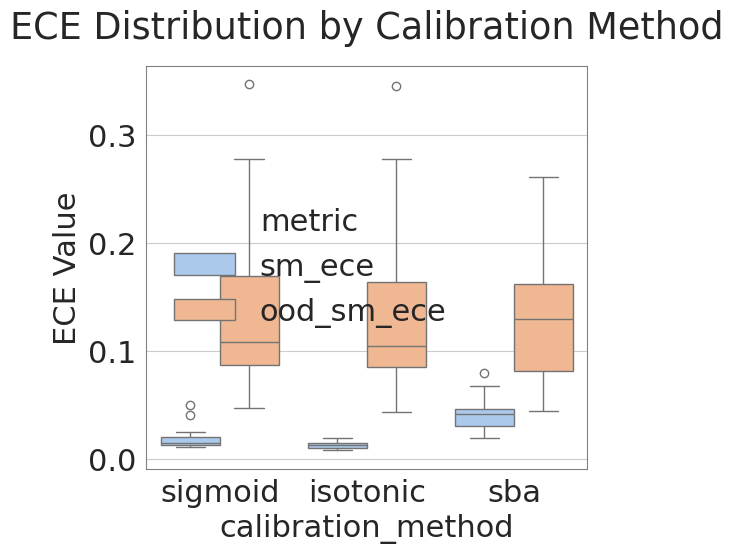

In [13]:
import seaborn as sns

plot_data = pd.melt(
    results_df,
    id_vars=["calibration_method"],
    value_vars=["sm_ece", "ood_sm_ece"],
    var_name="metric",
    value_name="value"
)

sns.boxplot(
    data=plot_data,
    x="calibration_method",
    y="value",
    hue="metric",
)
plt.title("ECE Distribution by Calibration Method")
plt.ylabel("ECE Value")

plt.tight_layout()
plt.show()

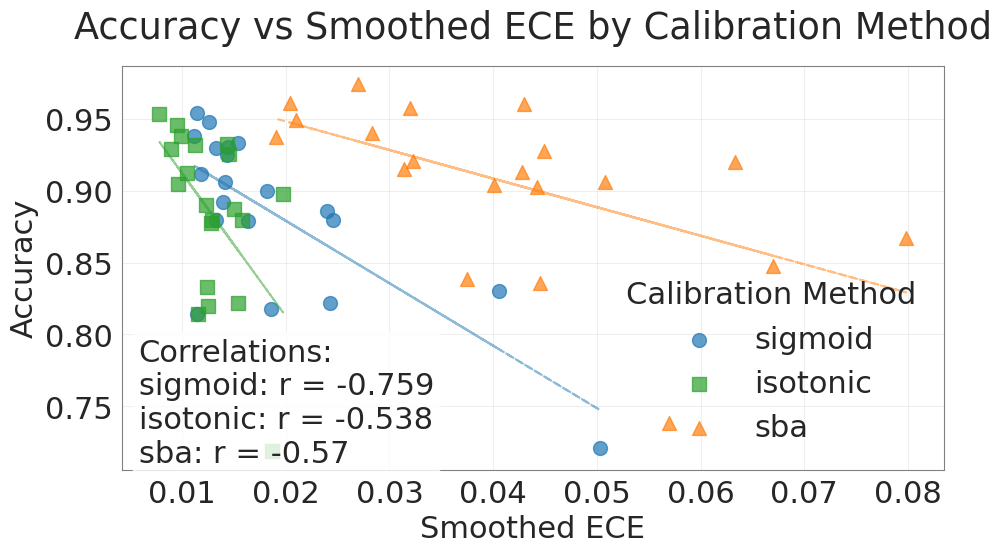

In [14]:
plt.figure(figsize=(10, 6))
colors = ["#1f77b4", "#2ca02c", "#ff7f0e"]
markers = ["o", "s", "^"]

for method, color, marker in zip(["sigmoid", "isotonic", "sba"], colors, markers):
    method_data = results_df[results_df["calibration_method"] == method]
    plt.scatter(
        method_data["sm_ece"],
        method_data["accuracy"],
        label=method,
        alpha=0.7,
        c=color,
        marker=marker,
        s=100
    )

    z = np.polyfit(method_data["sm_ece"], method_data["accuracy"], 1)
    p = np.poly1d(z)
    plt.plot(
        method_data["sm_ece"],
        p(method_data["sm_ece"]),
        c=color,
        linestyle="--",
        alpha=0.5
    )

plt.xlabel("Smoothed ECE")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Smoothed ECE by Calibration Method")
plt.legend(title="Calibration Method")
plt.grid(True, alpha=0.3)

# Add correlation information as text
correlations = []
for method in ["sigmoid", "isotonic", "sba"]:
    method_data = results_df[results_df["calibration_method"] == method]
    corr = method_data["accuracy"].corr(method_data["sm_ece"]).round(3)
    correlations.append(f"{method}: r = {corr}")

plt.text(
    0.02,
    0.02,
    "Correlations:\n" + "\n".join(correlations),
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.show()